# Steady-state analysis



In [130]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
%matplotlib inline
#%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)
from refl1d.names import *

## Set up the environment

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RESET


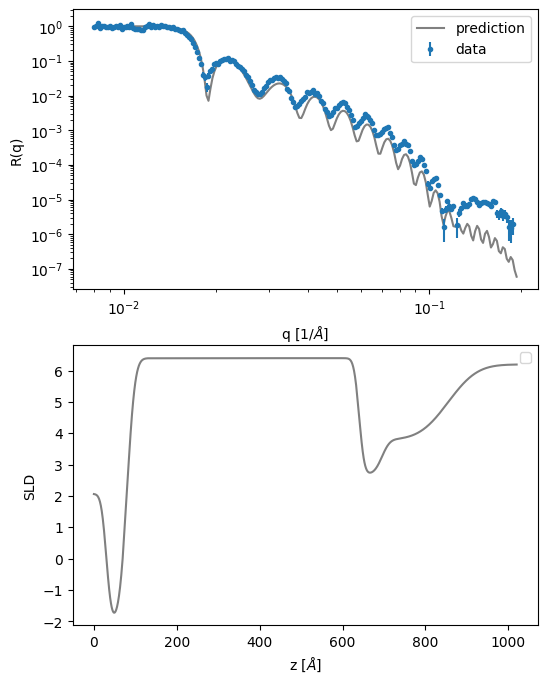

In [106]:
import steady_state
importlib.reload(steady_state)

# OCV 1
data_file = os.path.join(git_dir, 'data', 'REFL_207268_combined_data_auto.txt')

# OCV 2
data_file = os.path.join(git_dir, 'data', 'REFL_207282_combined_data_auto.txt')

RUN = 206983
data_file = os.path.join(git_dir, 'data', 'REFL_%d_combined_data_auto.txt' % RUN)

_data = np.loadtxt(data_file).T
#_data[1] = _data[1]/1.06

# Initial state is entered as a list of layers.
# First layer is the incoming medium.
# Layer parameter [0:thickness, 1:interface, 2:rho, 3:irho]

initial_state = [[0, 55, 6.2, 0],
                 [160, 15, 3.8, 0],
                 #[20, 15, 3.8, 0],
                 #[20, 15, 3.8, 0],
                 [55, 10, 2.7, 0],
                 [560, 15, 6.4, 0],
                 [50, 10, -2, 0],
                 #[20, 3, 3.2, 0],
                 [0, 0, 2.07, 0]
                ]
if False:
    initial_state = [[0, 10, 6.2, 0],
                    [20, 10, 5, 0],
                    [560, 5, 6.4, 0],
                    [50, 5, -2, 0],
                    #[20, 3, 3.2, 0],
                    [0, 0, 2.07, 0]
                    ]

# create an instance of our custom environment
env = steady_state.AnalyzerEnv(initial_state=initial_state,
                               data=_data, engine='amoeba')

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
print("RESET")
env.reset()
env.plot(errors=True)


## Train or load model

In [107]:
%%time

from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=100,
    save_path=os.path.join(git_dir, "notebooks", "logs-%s-entropy/" % RUN),
    name_prefix="steady-state",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)  #, device='cuda')
env.engine = 'dream'
if False:
    model.learn(2000, callback=checkpoint_callback)
    #model.learn(80000, callback=checkpoint_callback)
    model.save('steady-state-%s' % RUN)
else:
    model_file = os.path.join(git_dir, "notebooks", "logs-%s-entropy/" % RUN, 'steady-state_3000_steps')
    model = SAC.load(model_file)

CPU times: user 23.7 ms, sys: 75.6 ms, total: 99.3 ms
Wall time: 102 ms


## Run the agent on the time series data

Starting chi2: 28.5395
# steps: 7, # draws: 1050
0: 0 3.80696 0.7 [False]

# steps: 7, # draws: 1050
1: 19.3571 2.0745 0.7 [False]

# steps: 6, # draws: 1080
2: -7.06304 1.78928 0.8 [False]

# steps: 5, # draws: 1050
3: -8.28254 1.6758 0.9 [False]

# steps: 5, # draws: 1050
4: -31.7136 2.41561 0.9 [False]

# steps: 5, # draws: 1050
5: 42.4358 1.62817 0.9 [False]

# steps: 5, # draws: 1050
6: -3.13078 1.37995 0.9 [False]



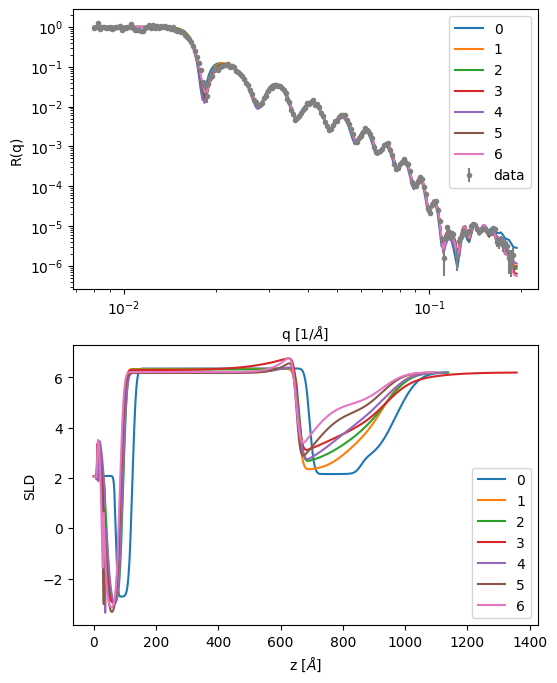

Chi2 = 1.37995
Entropy = 12.8208


In [117]:
# Evaluate the agent

obs, info = env.reset()
env.reward_cutoff = 1.31
env.engine = 'amoeba'
env.engine = 'dream'
print("Starting chi2: %g" % env.chi2_0)
chi2 = []
scale = 1

fig, axs = plt.subplots(2, 1, dpi=100, figsize=(6,8), sharex=False)
idx = env.data[1] > env.data[2]

for i in range(7):
    action, _ = model.predict(obs, deterministic=True)
    #print(action)
    chi2.append(env.chi2)
    new_obs, reward, terminated, truncated, info = env.step(action, False)  
    print("%d: %g %g %g [%s]\n" % (i, reward, env.chi2, env.state[0], terminated))
    if truncated:
        env.reset()
    else:
        obs = new_obs

    ax = plt.subplot(2, 1, 1)
    plt.plot(env.q, env.refl*scale, label=str(i))
    ax = plt.subplot(2, 1, 2)
    plt.plot(env.z[-1] - env.z, env.sld, label=str(i))

    if terminated:
        break

ax = plt.subplot(2, 1, 1)
plt.errorbar(env.data[0][idx], env.data[1][idx]*scale,
                         yerr=env.data[2][idx]*scale, label='data', linestyle='', marker='.', color='gray')
plt.gca().legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
plt.xscale('log')
plt.yscale('log')

ax = plt.subplot(2, 1, 2)
plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD')

plt.show()

print('Chi2 = %g' % env.chi2)
print('Entropy = %g' % env.entropy)

# Compute uncertainties

In [149]:
"""
  Show an uncertainty band for an SLD profile.
  This currently works for inverted geometry and fixed substrate roughness, as it aligns
  the profiles to that point before doing the statistics.
"""
from refl1d import errors
import numpy as np


def get_sld_contour(problem, state, cl=90, npoints=1000, trim=1000, portion=.3, index=1, align='auto'):
    points, _logp = state.sample(portion=portion)
    #points = points[-trim:-1]
    points = points[:trim]
    original = problem.getp()
    _profiles, slabs, Q, residuals = errors.calc_errors(problem, points)
    problem.setp(original)
    
    profiles = errors.align_profiles(_profiles, slabs, align)

    # Group 1 is rho
    # Group 2 is irho
    # Group 3 is rhoM
    contours = []
    for model, group in profiles.items():
        ## Find limits of all profiles
        z = np.hstack([line[0] for line in group])
        zp = np.linspace(np.min(z), np.max(z), npoints)

        # Columns are z, best, low, high
        data, cols = errors._build_profile_matrix(group, index, zp, [cl])
        contours.append(data)
    return contours



In [147]:
env.reset()
env.compute_reflectivity_from_state(False)
pars = env._get_pars_from_state()
experiment, n_fit_pars = env._get_experiment_from_pars(pars)

problem = FitProblem(experiment)

# steps: 9, # draws: 1080


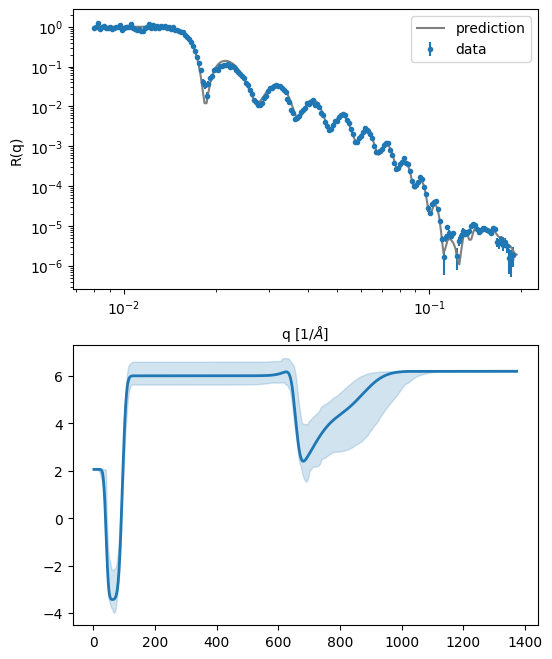

In [148]:
from bumps.fitters import fit

fig, axs = plt.subplots(2,1, dpi=100, figsize=(6,8), sharex=False)

results = fit(problem, method='dream', samples=1000, burn=1000, verbose=None)

q, r = experiment.reflectivity()
ax = plt.subplot(2, 1, 1)
plt.errorbar(env.data[0][idx], env.data[1][idx]*scale,
                yerr=env.data[2][idx]*scale, label='data', linestyle='', marker='.')
plt.plot(q, r, color='gray', label='prediction')

plt.gca().legend()
plt.xlabel('q [$1/\AA$]')
plt.ylabel('R(q)')
plt.xscale('log')
plt.yscale('log')

z, best, low, high = get_sld_contour(problem, results.state, cl=95, align=-1)[0]

ax = plt.subplot(2, 1, 2)
_z = z[i]-z+0
plt.plot(_z[:i], best[:i], markersize=4, label='best', linewidth=2,)
plt.fill_between(_z[:i], low[:i], high[:i], alpha=0.2, color=plt.gca().lines[-1].get_color())